In [1]:
import pandas as pd
from datetime import datetime
import random
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import warnings 
warnings.filterwarnings('ignore') 

DataFrame baixado no Kaggle: https://www.kaggle.com/ricardomattos05/brazilian-soccer-database

In [2]:
df = pd.read_csv('Brasileirao_Matches.csv')

df.head()

,datetime,home_team,home_team_state,away_team,away_team_state,home_goal,away_goal,season,round
0,2012-05-19 18:30:00,Palmeiras,SP,Portuguesa,SP,1.0,1.0,2012,1
1,2012-05-19 18:30:00,Sport,PE,Flamengo,RJ,1.0,1.0,2012,1
2,2012-05-19 21:00:00,Figueirense,SC,Náutico,PE,2.0,1.0,2012,1
3,2012-05-20 16:00:00,Ponte Preta,SP,Atlético,MG,0.0,1.0,2012,1
4,2012-05-20 16:00:00,Corinthians,SP,Fluminense,RJ,0.0,1.0,2012,1


Transforma a data num objeto datetime

In [3]:
df.datetime = pd.to_datetime(df.datetime)

df = df.dropna()

df.head()

,datetime,home_team,home_team_state,away_team,away_team_state,home_goal,away_goal,season,round
0,2012-05-19 18:30:00,Palmeiras,SP,Portuguesa,SP,1.0,1.0,2012,1
1,2012-05-19 18:30:00,Sport,PE,Flamengo,RJ,1.0,1.0,2012,1
2,2012-05-19 21:00:00,Figueirense,SC,Náutico,PE,2.0,1.0,2012,1
3,2012-05-20 16:00:00,Ponte Preta,SP,Atlético,MG,0.0,1.0,2012,1
4,2012-05-20 16:00:00,Corinthians,SP,Fluminense,RJ,0.0,1.0,2012,1


# PREPARANDO OS DADOS

Adapta o nome para não correr o risco de haver times com nomes iguais, atlético por exemplo

In [4]:
df.home_team = df.home_team + ' ' + df.home_team_state
df.away_team = df.away_team + ' ' + df.away_team_state

df.head()

,datetime,home_team,home_team_state,away_team,away_team_state,home_goal,away_goal,season,round
0,2012-05-19 18:30:00,Palmeiras SP,SP,Portuguesa SP,SP,1.0,1.0,2012,1
1,2012-05-19 18:30:00,Sport PE,PE,Flamengo RJ,RJ,1.0,1.0,2012,1
2,2012-05-19 21:00:00,Figueirense SC,SC,Náutico PE,PE,2.0,1.0,2012,1
3,2012-05-20 16:00:00,Ponte Preta SP,SP,Atlético MG,MG,0.0,1.0,2012,1
4,2012-05-20 16:00:00,Corinthians SP,SP,Fluminense RJ,RJ,0.0,1.0,2012,1


Cria um dicionário para facilitar a manipulação dos dados, onde cada clube tem sua chave

In [5]:
jogos = dict()

for i in df.home_team.unique():
    df_temp = df.loc[(df.home_team == i)|(df.away_team == i)] # DataFrame temporario onde o clube ou jogou em casa ou fora
    df_temp['clube'] = i
    jogos[i] = df_temp # Salva o DataFrame no dicionário

Cria um novo DataFrame que vai armazenar todos os dataframes anteriormente salvos

In [6]:
df_jogos = pd.DataFrame()

for i in jogos.keys():
    df_jogos = df_jogos.append(jogos[i], ignore_index=True)
    
df_jogos.head()

,datetime,home_team,home_team_state,away_team,away_team_state,home_goal,away_goal,season,round,clube
0,2012-05-19 18:30:00,Palmeiras SP,SP,Portuguesa SP,SP,1.0,1.0,2012,1,Palmeiras SP
1,2012-05-27 18:30:00,Grêmio RS,RS,Palmeiras SP,SP,1.0,0.0,2012,2,Palmeiras SP
2,2012-06-06 19:30:00,Sport PE,PE,Palmeiras SP,SP,2.0,1.0,2012,3,Palmeiras SP
3,2012-06-09 21:00:00,Palmeiras SP,SP,Atlético MG,MG,0.0,1.0,2012,4,Palmeiras SP
4,2012-06-17 16:00:00,Palmeiras SP,SP,Vasco da Gama RJ,RJ,1.0,1.0,2012,5,Palmeiras SP


Marca onde o clube da coluna clube venceu ou empatou e remove algumas colunas que não serão mais úteis

In [7]:
for i in df_jogos.clube.unique():
    df_jogos.loc[(df_jogos.clube == i) & (df_jogos.home_goal == df_jogos.away_goal), 'aproveitamento'] = 0.333
    
    df_jogos.loc[(df_jogos.clube == i) & (df_jogos.home_team == df_jogos.clube) & (df_jogos.home_goal > df_jogos.away_goal), 'aproveitamento'] = 1
    df_jogos.loc[(df_jogos.clube == i) & (df_jogos.home_team == df_jogos.clube) & (df_jogos.home_goal < df_jogos.away_goal), 'aproveitamento'] = 0    
    
    df_jogos.loc[(df_jogos.clube == i) & (df_jogos.away_team == df_jogos.clube) & (df_jogos.home_goal < df_jogos.away_goal), 'aproveitamento'] = 1
    df_jogos.loc[(df_jogos.clube == i) & (df_jogos.away_team == df_jogos.clube) & (df_jogos.home_goal > df_jogos.away_goal), 'aproveitamento'] = 0 
    
df_jogos = df_jogos.drop(columns=['home_team', 'home_team_state', 'away_team', 'away_team_state', 'home_goal', 'away_goal'])
df_jogos = df_jogos.sort_values('datetime')

df_jogos.head()

,datetime,season,round,clube,aproveitamento
0,2012-05-19 18:30:00,2012,1,Palmeiras SP,0.333
2941,2012-05-19 18:30:00,2012,1,Flamengo RJ,0.333
325,2012-05-19 18:30:00,2012,1,Sport PE,0.333
3302,2012-05-19 18:30:00,2012,1,Portuguesa SP,0.333
613,2012-05-19 21:00:00,2012,1,Figueirense SC,1.000


Agora salva-se cada tabela de jogos de um clube novamente em um dicionário e aplica as transformações necessárias afim de estruturar os dados da forma desejada.

A operação é relativamente demorada (cerca de 4 segundos), mas foi a melhor solução (e com uma boa vantagem)  encontrada.

In [8]:
jogos = dict()

for i in df_jogos.clube.unique():
    jogos[i] = df_jogos.loc[(df_jogos.clube == i)] # Salva o DataFrame no dicionário
    
for clube in df_jogos.clube.unique(): # Itera cada clube
    
    temporadas = pd.DataFrame() # Arquivo temporario pra cada clube
    
    for ano in df_jogos.loc[df_jogos.clube==clube, 'season'].unique(): # Itera cada ano
        
        temp = jogos[clube].loc[jogos[clube].season == ano] # Arquivo temporario para o tratamento de cada ano
        
        temp['mm_5_anteriores'] = temp['aproveitamento'].rolling(5).mean().shift(1)
        temp['mm_5_posteriores'] = temp['aproveitamento'].rolling(5).mean().shift(-5)
        
        temp['mm_10_anteriores'] = temp['aproveitamento'].rolling(10).mean().shift(1)
        temp['mm_10_posteriores'] = temp['aproveitamento'].rolling(10).mean().shift(-10)
        
        temporadas = temporadas.append(temp, ignore_index=True)
        
    jogos[clube] = temporadas


df_jogos = pd.DataFrame()
for i in jogos.keys():
    df_jogos = df_jogos.append(jogos[i], ignore_index=True)

df_jogos.head()

,datetime,season,round,clube,aproveitamento,mm_5_anteriores,mm_5_posteriores,mm_10_anteriores,mm_10_posteriores
0,2012-05-19 18:30:00,2012,1,Palmeiras SP,0.333,NaN,0.0666,NaN,0.2999
1,2012-05-27 18:30:00,2012,2,Palmeiras SP,0.000,NaN,0.2666,NaN,0.2999
2,2012-06-06 19:30:00,2012,3,Palmeiras SP,0.000,NaN,0.2666,NaN,0.2999
3,2012-06-09 21:00:00,2012,4,Palmeiras SP,0.000,NaN,0.3332,NaN,0.2999
4,2012-06-17 16:00:00,2012,5,Palmeiras SP,0.333,NaN,0.3332,NaN,0.3666


Arrendona para uma casa decimal os aproveitamentos e encerra a etapa de preparo dos dados

In [9]:
df_jogos.mm_5_anteriores = df_jogos.mm_5_anteriores.apply(lambda x: round(x, 1))
df_jogos.mm_5_posteriores = df_jogos.mm_5_posteriores.apply(lambda x: round(x, 1))

df_jogos.mm_10_anteriores = df_jogos.mm_10_anteriores.apply(lambda x: round(x, 1))
df_jogos.mm_10_posteriores = df_jogos.mm_10_posteriores.apply(lambda x: round(x, 1))

df_jogos.head()

,datetime,season,round,clube,aproveitamento,mm_5_anteriores,mm_5_posteriores,mm_10_anteriores,mm_10_posteriores
0,2012-05-19 18:30:00,2012,1,Palmeiras SP,0.333,NaN,0.1,NaN,0.3
1,2012-05-27 18:30:00,2012,2,Palmeiras SP,0.000,NaN,0.3,NaN,0.3
2,2012-06-06 19:30:00,2012,3,Palmeiras SP,0.000,NaN,0.3,NaN,0.3
3,2012-06-09 21:00:00,2012,4,Palmeiras SP,0.000,NaN,0.3,NaN,0.3
4,2012-06-17 16:00:00,2012,5,Palmeiras SP,0.333,NaN,0.3,NaN,0.4


# VISUALIZANDO OS DADOS

Boxplot da dispersão entre os 5 jogos seguintes, dado o aproveitamento nos 10 anteriores

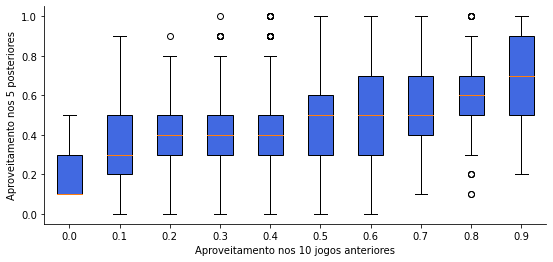

In [10]:
box_5_10 = []

for i in df_jogos.mm_10_anteriores.dropna().sort_values().unique(): # Itera os valores possíveis para mm_10
    temp = df_jogos.loc[(df_jogos.mm_10_anteriores == i), 'mm_5_posteriores'].dropna() 
    
    box_5_10.append(temp) # Salva ele numa lista
    
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))

legenda = [str(x) for x in df_jogos.mm_10_anteriores.dropna().sort_values().unique()] # Lista de legendas
# rectangular box plot
bplot = ax.boxplot(box_5_10,
                     patch_artist=True, 
                     labels=legenda)


for box in bplot['boxes']:
    box.set_facecolor('#4169E1')

ax.set_xlabel('Aproveitamento nos 10 jogos anteriores')
ax.set_ylabel('Aproveitamento nos 5 posteriores')
ax.spines['right'].set_visible(False)          
ax.spines['top'].set_visible(False)

plt.savefig('boxplot.png', dpi=400)

Funcao que vai nos ajudar a remover figuras, tirada da documentação oficial.

link: https://matplotlib.org/stable/gallery/lines_bars_and_markers/markevery_demo.html?highlight=trim_axs

In [11]:
def remove_axs(axs, N):
    
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

Analisa como é a distribuição por faixas de aproveitamento de maneira "frontal"

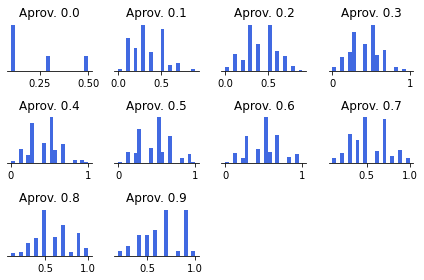

In [13]:
fig, axs = plt.subplots(3,4, tight_layout=True)

N = len(df_jogos.mm_10_anteriores.dropna().sort_values().unique()) # Numero de graficos
axs = remove_axs(axs, N)

for i in range(N):
    
    faixa = df_jogos.mm_10_anteriores.dropna().sort_values().unique()[i]
    x = df_jogos.loc[(df_jogos.mm_10_anteriores == faixa), 'mm_5_posteriores'].dropna()
    
    axs[i].hist(x, bins=20, color='#4169E1')
    axs[i].set_title(f'Aprov. 0.{i}')
    axs[i].get_yaxis().set_visible(False)
    axs[i].spines['right'].set_visible(False)          
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['left'].set_visible(False)
    
plt.savefig('distribuicoes de aproveitamento', dpi=400)

Une as classes nos extremos devida a baixa incidencia

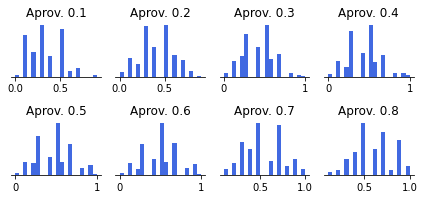

In [14]:
df_dados = df_jogos.copy() # Cria novo dataframe por seguranca

# Une as classes que estão nos extremos
df_dados.loc[(df_jogos.mm_10_anteriores == 0.0), 'mm_10_anteriores'] = 0.1
df_dados.loc[(df_jogos.mm_10_anteriores == 0.9), 'mm_10_anteriores'] = 0.8

# Plota o gráfico anterior
fig, axs = plt.subplots(3,4, tight_layout=True)

N = len(df_dados.mm_10_anteriores.dropna().sort_values().unique())
axs = remove_axs(axs, N)

for i in range(N):
    
    faixa = df_dados.mm_10_anteriores.dropna().sort_values().unique()[i]
    x = df_dados.loc[(df_dados.mm_10_anteriores == faixa), 'mm_5_posteriores'].dropna()

    axs[i].hist(x, bins=20, color='#4169E1')
    axs[i].set_title(f'Aprov. 0.{i+1}')
    axs[i].get_yaxis().set_visible(False)
    axs[i].spines['right'].set_visible(False)          
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['left'].set_visible(False)
    
plt.savefig('distribuicoes com novas classes.png', dpi=400)

# Etapa final: estimando os parametros populacionais

faixas de aproveitamento e seus respectivos parametros

In [15]:
faixas = dict()

for i in range(len(df_dados.mm_10_anteriores.dropna().sort_values().unique())):
    
    faixa = df_dados.mm_10_anteriores.dropna().sort_values().unique()[i]
    x = df_dados.loc[(df_dados.mm_10_anteriores == faixa), 'mm_5_posteriores'].dropna()
    faixas[faixa] = [round(x.mean(), 3), round(x.std(),3)]
    
faixas

{0.1: [0.332, 0.181],
 0.2: [0.411, 0.187],
 0.3: [0.417, 0.192],
 0.4: [0.432, 0.198],
 0.5: [0.476, 0.214],
 0.6: [0.495, 0.213],
 0.7: [0.537, 0.214],
 0.8: [0.607, 0.211]}

Simula a populacao teorica a partir dos parametros da observada

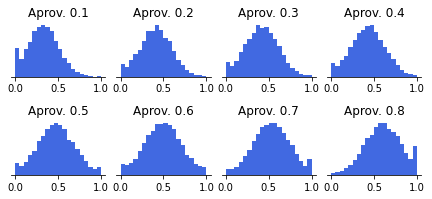

In [16]:
fig, axs = plt.subplots(3,4, tight_layout=True)

axs = remove_axs(axs, len(faixas.keys()))
i = 0

for faixa in faixas.keys():
    
    curva = faixas[faixa]
    x = np.random.normal(curva[0], curva[1], 10000)
    x[x<0] = 0
    x[x>1] = 1
    
    axs[i].hist(x, bins=20, color='#4169E1')
    axs[i].set_title(f'Aprov. 0.{1+i}')
    axs[i].get_yaxis().set_visible(False)
    axs[i].spines['right'].set_visible(False)          
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['left'].set_visible(False)
    
    i+=1
    
plt.savefig('distribuição teorica.png', dpi=400)

Salva as faixas para ser usado na simulação

In [17]:
faixas = pd.DataFrame(faixas).T
faixas.columns = ['media', 'dp']

faixas.to_csv('distribuicoes.csv')

faixas

,media,dp
0.1,0.332,0.181
0.2,0.411,0.187
0.3,0.417,0.192
0.4,0.432,0.198
0.5,0.476,0.214
0.6,0.495,0.213
0.7,0.537,0.214
0.8,0.607,0.211
